In [65]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from behavioural_benchmark.visualisation import Visualisation
sns.set_style("white")

In [2]:
results = pd.read_csv("../results.csv", names=["experiment", "dim", "population_size", "iterations", "function", "metaheuristic", "control_params"] + [f"col_{i}" for i in range(26)])

In [3]:
results.head()

,experiment,dim,population_size,iterations,function,metaheuristic,control_params,col_0,col_1,col_2,...,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25
0,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},10,-0.003475,-0.000003,...,0.051248,4840,12,294,800.166667,8.107143,0.631548,1.2975,8.762524,0.037608
1,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},30,-0.004983,-0.000021,...,0.060235,4434,23,305,824.400000,8.932203,0.664407,1.3545,6.790226,0.038918
2,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},5,-0.004656,-0.000018,...,0.028174,3359,20,300,847.066667,8.258621,0.674138,1.3630,6.123929,0.045055
3,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},3,-0.004941,-0.000034,...,0.026478,4374,19,319,809.500000,8.370968,0.672043,1.3235,7.182740,0.062709
4,characteristicTest,10,30,1000,Weierstrass,VonNeumannPSO,{c1=0.7; c2=0.7; w=0.9},21,-0.003746,-0.000010,...,0.025653,5717,30,392,767.300000,8.206897,0.694253,1.2010,9.943356,0.072246


In [4]:
vis = Visualisation(results)

In [5]:
columns = ['col_1', 'col_2', 'col_3']
metaheuristics = ['VonNeumannPSO', 'RingPSO']#, 'GBestPSO']
function = ['Weierstrass']
filter = {"metaheuristic": metaheuristics, "function": function}

In [6]:
prepped_data = vis.__prep_data__(columns=columns, filters=filter, exclude_outliers=True, normalise=True)

# KDE Plots

Text(0, 0.5, '')

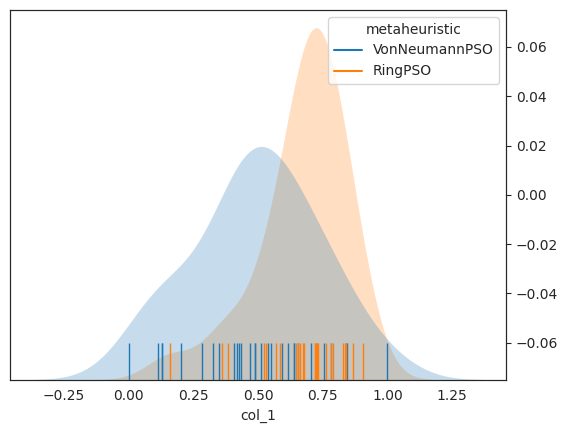

In [173]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
sns.kdeplot(x='col_1', data=prepped_data, hue='metaheuristic', fill=True, ax=ax, linewidth=0, legend=False)
sns.rugplot(x='col_1', data=prepped_data, hue='metaheuristic', ax=ax2, legend=True, height=0.1, clip_on=True)
ax.set_yticks([])
ax.set_ylabel('')

<Axes: xlabel='col_1', ylabel='col_2'>

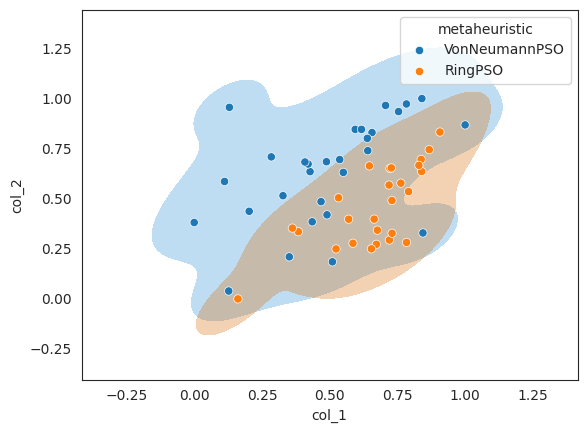

In [64]:
fig, ax = plt.subplots()
sns.set_style("white")
sns.kdeplot(x='col_1', y='col_2', data=prepped_data, hue='metaheuristic', fill=True, alpha=.3, ax=ax, bw_adjust=1, levels=2)
sns.scatterplot(x='col_1', y='col_2', data=prepped_data, hue='metaheuristic', ax=ax)

# Venn Diagram

In [174]:
from sklearn.neighbors import KernelDensity

def overlap():
    

red_points = prepped_data[prepped_data['metaheuristic'] == 'VonNeumannPSO'][columns]
green_points = prepped_data[prepped_data['metaheuristic'] == 'RingPSO'][columns]

# Fit KDE for both red and green points
kde_red = KernelDensity()
kde_red.fit(red_points)

kde_green = KernelDensity()
kde_green.fit(green_points)

# Evaluate overlap
# We sample a set of points to estimate the overlap in high-dimensional space
sample_points = np.vstack((red_points, green_points))
log_density_red = kde_red.score_samples(sample_points)
log_density_green = kde_green.score_samples(sample_points)

# Convert log densities to probabilities
density_red = np.exp(log_density_red)
density_green = np.exp(log_density_green)

# Calculate overlap
overlap = np.sum(np.minimum(density_red, density_green)) / np.sum(density_red + density_green)
overlap_percentage = overlap * 100

print(f"Estimated overlap percentage: {overlap_percentage:.2f}%")

Estimated overlap percentage: 48.44%


/home/lauren/git/code_masters/behaviouralBenchmarking/.venv2/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(
/home/lauren/git/code_masters/behaviouralBenchmarking/.venv2/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KernelDensity was fitted with feature names
  warnings.warn(


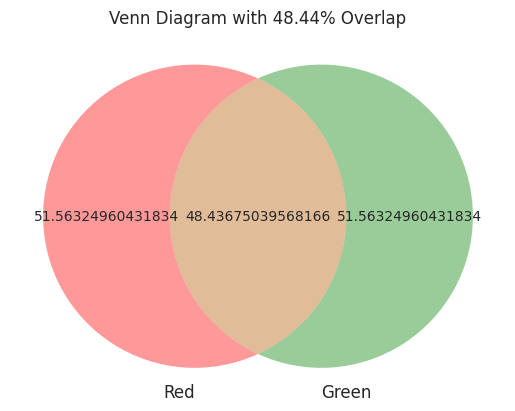

In [175]:
from matplotlib_venn import venn2, venn3

set_size = 100
overlap_size = set_size * (overlap_percentage / 100)
only_red_size = set_size - overlap_size
only_green_size = set_size - overlap_size

# Draw the Venn diagram
venn2(subsets=(only_red_size, only_green_size, overlap_size), set_labels=('Red', 'Green'))

# Add title and display the plot
plt.title(f'Venn Diagram with {overlap_percentage:.2f}% Overlap')
plt.show()